In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q transformers

     |████████████████████████████████| 3.5 MB 6.2 MB/s 
     |████████████████████████████████| 6.8 MB 53.3 MB/s 
     |████████████████████████████████| 596 kB 46.7 MB/s 
     |████████████████████████████████| 895 kB 49.8 MB/s 
     |████████████████████████████████| 67 kB 3.8 MB/s 


In [3]:
import pandas as pd
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

from torch import cuda

import re
import sys

tqdm.pandas()


In [4]:
num_rec = 3000000

reviews = []
with open('/content/drive/MyDrive/Thesis/Yelp/yelp_academic_dataset_review.json') as f:
    i=1
    for i, line in enumerate(f):
        reviews.append(json.loads(line))
        if i+1 >= num_rec:
           break


In [5]:
data = pd.DataFrame(reviews)

In [6]:
def isEnglish(sentence):
  return sentence.isascii()   
data['isenglish'] = data['text'].apply(isEnglish)


In [7]:
data_nEng=data[data["isenglish"]==False]

In [8]:
data_nEng.sample(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,isenglish
2074257,WO2RJ3pumeNKzzmhu6U8nA,4DyQl2hSxSOxLhbhYfuNFw,CgZfMVFv0ilEDZbH06apyA,4.0,1,1,2,Delicious breakfast tacos with fluffy perfectl...,2016-01-10 17:50:12,False
57063,RS28zBRb-RmSXSsZgpJQFg,Hp_SA33cTtbQ1iK7IwAMng,H_RM2u1WWGU1HkKZrYq2Ow,4.0,0,0,0,Blue star over voodoo donuts! They have a vari...,2016-12-21 17:49:42,False
1217612,etU8m8wpqA82lS5S55NLug,wM5xJ61cPe9R-b73tYW6lw,zGLxRRRLd9P-zrOIB6fB8Q,2.0,0,0,0,"Oh, Café intermezzo! How I wish you could be b...",2013-02-13 21:38:01,False
1836374,BotWLSe6GN1-M9bA_4AY7A,TJXkIWsaIu6GO6aKo8N02g,Xph7Vfqxyjyynr-aE06fMg,5.0,0,0,0,Great place . Very accommodating with food in...,2018-08-07 01:41:33,False
2632474,6MrHWmDjhlXhA45OeIvm3g,E5T9JQBlC5yGvZqqkBpphg,Ea3bF4jar0KigTlkuuwCRg,1.0,3,0,1,El Potro\n\nEl Potro\n\n4.4\n\n(206)\n\nMexica...,2017-09-21 14:51:59,False


In [9]:
data_nEng[data_nEng['review_id']=='kufcMn3XLJXSddMNqj_YHQ']['text']

834683    Los mejores sándwich de brisket que eh probado...
Name: text, dtype: object

In [10]:
data=data[data["isenglish"]==True]

In [ ]:
# see duplicated value
#duplicateRowsDF = data[data.duplicated(['text'])]

In [11]:
del reviews

In [12]:
data.describe(include = 'all')

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,isenglish
count,2943543,2943543,2943543,2.943543e+06,2.943543e+06,2.943543e+06,2.943543e+06,2943543,2943543,2943543
unique,2943543,1151611,62283,NaN,NaN,NaN,NaN,2938253,2925786,1
top,8bFej1QE5LXp4O05qjGqXA,RtGqdDBvvBCjcu5dUqwfzA,OQ2oHkcWA8KNC1Lsvj1SBA,NaN,NaN,NaN,NaN,Are you kidding me? Anything less than 5 stars...,2014-01-21 09:39:52,True
freq,1,2125,7312,NaN,NaN,NaN,NaN,15,4,2943543
mean,NaN,NaN,NaN,3.730525e+00,1.220625e+00,4.039778e-01,4.738236e-01,NaN,NaN,NaN
std,NaN,NaN,NaN,1.452173e+00,3.106180e+00,1.721630e+00,1.995184e+00,NaN,NaN,NaN
min,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
50%,NaN,NaN,NaN,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
75%,NaN,NaN,NaN,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN


In [13]:
#remove duplicated value
data =data.drop_duplicates(['text'])

In [14]:
data.describe(include = 'all')

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,isenglish
count,2938253,2938253,2938253,2.938253e+06,2.938253e+06,2.938253e+06,2.938253e+06,2938253,2938253,2938253
unique,2938253,1151553,62283,NaN,NaN,NaN,NaN,2938253,2920586,1
top,8bFej1QE5LXp4O05qjGqXA,RtGqdDBvvBCjcu5dUqwfzA,OQ2oHkcWA8KNC1Lsvj1SBA,NaN,NaN,NaN,NaN,This store is pretty good. Not as great as Wal...,2013-03-04 05:19:29,True
freq,1,2113,7294,NaN,NaN,NaN,NaN,1,4,2938253
mean,NaN,NaN,NaN,3.730398e+00,1.221375e+00,4.043651e-01,4.742039e-01,NaN,NaN,NaN
std,NaN,NaN,NaN,1.452008e+00,3.107732e+00,1.722948e+00,1.996639e+00,NaN,NaN,NaN
min,NaN,NaN,NaN,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
25%,NaN,NaN,NaN,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
50%,NaN,NaN,NaN,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
75%,NaN,NaN,NaN,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN


In [15]:
data.head(3)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,isenglish
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25,True
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06,True
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15,True


In [16]:
data['stars_str'] = data['stars'] .replace({1.0:'1', 2.0:'2', 3.0:'3', 4.0:'4',5.0:'5'})

In [17]:
data['text'] = data['text'].str.replace('`',"'")

In [18]:
data =data.astype({'stars': 'int32'})
#data.dtypes

# Cleaning

##NULL

In [19]:
data[data.isna().any(axis=1)]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,isenglish,stars_str


## Star

In [20]:
y_count=[]
y_prop=[]
for i in range(1,6):
  y_count.append(data['stars_str'].value_counts().loc[str(i)])
  y_prop.append(((data['stars_str'].value_counts().loc[str(i)])/(data['stars'].shape[0])).round(3))


In [21]:
x = [1,2,3,4,5]

score_distribution_table = pd.DataFrame({'scores':x,'score_count':y_count,'score_%':y_prop})
score_distribution_table['score_%'] = score_distribution_table['score_%']*100

score_distribution_table

,scores,score_count,score_%
0,1,425028,14.5
1,2,243552,8.3
2,3,319439,10.9
3,4,660766,22.5
4,5,1289468,43.9


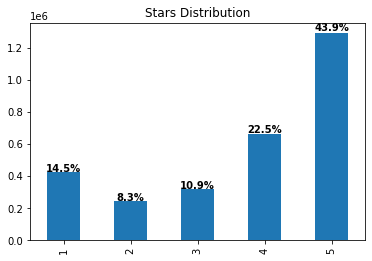

In [22]:
#plt.hist(data['stars_str'], bins = 5)
graph = data['stars_str'].value_counts().loc[['1', '2', '3','4','5']].plot.bar()
plt.title('Stars Distribution')
i=0
for p in graph.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(round(y_prop[i]*100,2))+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

## Useful

0-18

In [23]:
data['useful'].value_counts(sort=True)

0      1628090
1       620731
2       284491
3       146120
4        82188
        ...   
244          1
202          1
209          1
170          1
446          1
Name: useful, Length: 195, dtype: int64

In [25]:
?plt.hist

Text(0.5, 1.0, 'Useful')

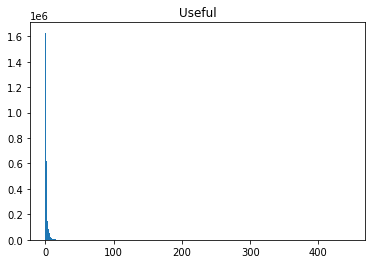

In [32]:
plt.hist(data['useful'],bins=np.arange(data['useful'].min(), data['useful'].max()+1))
plt.title("Useful")

In [31]:
data['useful'].unique()

array([  1,   0,   2,   3,   5,   4,   7,   8,   6,  12,  49,  13,  27,
         9,  16,  39,  20,  10,  26,  22,  11,  33,  19,  18,  24,  15,
        17,  25,  14,  23, 128,  41,  43,  32,  21,  31,  29,  36,  28,
        37,  30,  54,  50,  40,  89,  34, 122, 252,  42,  47,  44,  35,
       120,  45,  68,  82, 121,  38, 131, 113,  64, 112,  77, 119,  81,
        46, 132, 148,  69,  96, 118,  51, 100, 126, 115, 107, 134, 138,
       102, 141,  62,  93,  60, 137,  58, 116,  59, 123,  85, 105, 184,
        56,  66, 125,  74,  92,  75,  53,  52,  67,  88,  91,  71,  99,
        76,  80,  87, 101, 167,  72,  84,  83,  61,  48,  55,  73, 146,
       198, 150,  65, 190, 156,  70, 127,  57, 129,  86, 140, 152,  79,
       153, 109,  63, 212, 175, 143,  78, 124,  97, 133,  90, 343,  98,
       142, 284, 203, 210, 111, 104,  94, 135, 177, 162, 230, 159, 130,
       398, 200, 136, 244, 202, 209, 117, 158, 170, 164, 144, 166, 161,
       163, 154, 157, 108, 174, 149, 233, 147, 222, 160, 155, 13

In [ ]:

freq_useful = pd.crosstab(data['useful'], columns=['count'])
#find proportions 
freq_useful ['freq_%']=(freq_useful /freq_useful .sum()).round(3)*100
freq_useful [freq_useful ['freq_%']>=0.001]

col_0,count,freq_%
useful,,
0,1628090,55.4
1,620731,21.1
2,284491,9.7
3,146120,5.0
4,82188,2.8
5,49704,1.7
6,31775,1.1
7,21395,0.7
8,15371,0.5


In [ ]:
x=np.sort(data['useful'].unique())
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 170, 171, 173,
       174, 175, 177, 178, 179, 180, 184, 190, 191, 198, 200, 20

In [ ]:
len([0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 109, 110, 111, 112, 113, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 146,
       148, 150, 152, 153, 156, 158, 159, 160, 162, 164, 167, 170,171,
       172, 173, 174, 175, 177, 178, 179, 180])/len(x)

0.841025641025641

## Funny

0-9

In [33]:
data['funny'].value_counts(sort=True)

0      2400963
1       324532
2       100291
3        42639
4        22351
        ...   
149          1
195          1
113          1
110          1
264          1
Name: funny, Length: 126, dtype: int64

In [34]:
x=np.sort(data['funny'].unique())
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  93,  94,  95,  96,  97,  99, 101, 102, 104, 105, 106, 107,
       109, 110, 113, 115, 117, 118, 126, 128, 129, 132, 137, 149, 171,
       172, 184, 195, 207, 230, 234, 255, 264, 529])

In [ ]:
len([0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  93,  94,  95,  96,  97,  99, 100, 101, 102, 103, 105, 106,
       107, 109, 110])/len(x)

0.8492063492063492

Text(0.5, 1.0, 'Funny')

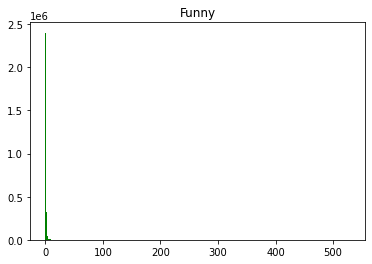

In [40]:
plt.hist(data['funny'],bins=np.arange(data['funny'].min(), data['funny'].max()+1),color="Green")
plt.title("Funny")

In [ ]:
freq_funny= pd.crosstab(index=data['funny'], columns='count')
#find proportions 
freq_funny['freq_%']=freq_funny['count'] /freq_funny['count'] .sum().round(3)*100
freq_funny[freq_funny ['freq_%']>=0.1]

col_0,count,freq_%
funny,,
0,2400963,81.713964
1,324532,11.045067
2,100291,3.413287
3,42639,1.451168
4,22351,0.760690
5,13046,0.444005
6,8386,0.285408
7,5723,0.194776
8,4207,0.143180


##Cool

In [38]:
data['cool'].value_counts(sort=True)

0      2287227
1       407113
2       122024
3        48279
4        23699
        ...   
150          1
118          1
121          1
530          1
149          1
Name: cool, Length: 152, dtype: int64

In [39]:
x=np.sort(data['cool'].unique())
x

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 120,
       121, 123, 124, 126, 128, 130, 132, 133, 135, 136, 137, 138, 141,
       143, 144, 146, 147, 149, 150, 151, 153, 155, 157, 168, 175, 176,
       182, 186, 220, 239, 243, 265, 339, 348, 530])

In [ ]:
x=[ 0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97, 100, 101, 102, 103, 104, 105,
       107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 120, 121,
       124, 126, 128, 130, 132, 133, 135, 137, 141, 143, 144, 146, 147,
       150, 151, 153, 154, 155, 157]
len(x)

136

In [ ]:
136/147

0.9251700680272109

Text(0.5, 1.0, 'Cool')

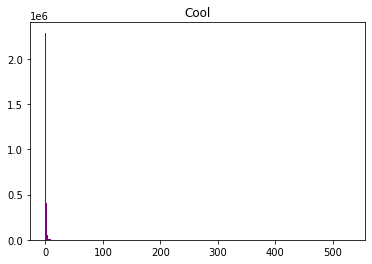

In [44]:
plt.hist(data['cool'],bins=np.arange(data['cool'].min(), data['cool'].max()+1),color = "Purple")
#plt.hist(data['cool'],bins=np.arange(data['cool'].min(), 50),color = "Purple")
plt.title("Cool")

In [ ]:
freq_cool= pd.crosstab(index=data['cool'], columns='count')
#find proportions 
freq_cool['freq_%']=freq_cool['count'] /freq_cool['count'] .sum().round(3)*100
freq_cool[freq_cool ['freq_%']>=0.1]

col_0,count,freq_%
cool,,
0,2287227,77.843092
1,407113,13.855614
2,122024,4.152944
3,48279,1.643119
4,23699,0.806568
5,13346,0.454215
6,8521,0.290002
7,5895,0.200629
8,4127,0.140458


## Word Count

In [ ]:
data['txt_len']=data['text'].str.len()


## Data Reselection Based on Len of Reviews

In [ ]:
data[(data['txt_len']>=5)&(data['txt_len']<=50)]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,isenglish,stars_str,txt_len
92,CK03ZpXOZjfJOEHFRL9TLg,wmJJs3LePX6KJwgMwUm2tQ,JCgLWYjoPJlznzFEtnzqKg,2,1,0,1,Nice staff. Subpar food for the price.,2013-03-18 18:06:09,True,2,38
143,U6nQnMjr2ZPT9W0xdrf5Tw,DVLN6wdRqZQMmHmCjqzeSw,0yl8_iGgj2wNCT43-7WPZA,2,1,1,0,Dime a dozen lounge near the Douche Ranch.\n\n...,2010-03-12 23:27:45,True,2,48
434,eELRc-VnanTk6WraXE53hQ,28PRlYM-9vh50kXfeFzN9g,QLQtO7YozohpjDZijLp-6w,4,0,0,0,Very good food!! I am glad it's close to home!!,2013-08-03 19:43:02,True,4,47
645,yiNcqrCNQnHYpnaBCzNDwg,QvZ2PLK32J35zUSURsEHqA,bJ45Stdd9UuLHMGqBxVzPg,4,0,0,1,Chill spot. Lax atmosphere. It gets smokey...,2013-10-24 04:14:44,True,4,47
822,u6IWKS59jzRfHtSM2PHy9w,2vzN0j4oEmf6eT3MqYDZbw,bZiIIUcpgxh8mpKMDhdqbA,4,0,0,0,Great place.. good burgers.. surely like this ...,2013-07-13 17:27:39,True,4,50
...,...,...,...,...,...,...,...,...,...,...,...,...
2996971,zzZSfx4coqNEnZjULSPSyw,kBLddRhPFJ35wZMsa4ebWA,cvODOGR-22hLvRcjCw7Vvw,5,1,0,0,best bar burger in ptown. hands down!,2013-12-20 15:27:54,True,5,38
2997597,a36X7I9H0tT4b3Asrjj5Hw,04Zueu-7JtXOtqP1Fzo-2A,rK-fgI2_-x0T4lxwF9L4Ww,5,0,0,0,love dad's bear and duck wings!,2016-12-14 19:05:58,True,5,31
2998234,Sn_gZb67Bz29kKRXUDAlGg,zsPV9jCkHZA-6JulQBOZEw,VjSUoCUZivCmCFkyywyPjA,5,0,0,0,awesome quick bite to eat and best off its halal,2016-05-02 19:22:57,True,5,48
2999078,36I7yGjbHec_vHsOTdCMDQ,GKsOsFrw3mEkqIuv_Uo-fA,MX-GPMbEFgKx6q1HeG5v_w,4,1,0,0,Shrimp po boy and some gumbo... Very good.,2008-04-09 02:37:36,True,4,43


In [ ]:
data1 = data[(data['useful']<19)& (data['useful']>=0)
       & (data['funny']<=9) &(data['funny']>=0)
       & (data['cool']<=9) &(data['cool']>=0)].reset_index(drop=True)

In [ ]:
MIN_LEN =50
data1 = data1[(data1['txt_len']>=MIN_LEN)]

In [ ]:
freq_cool= pd.crosstab(index=data['txt_len'], columns='count')


## Resample

In [ ]:
#resample
dfs = []
resampling=70000
for i in range(5):
    print(i,data1 [data1 ['stars'] == i+1].shape)
    dfs.append(data1[data1['stars']==i+1].sample(resampling,random_state=200))

df_r = pd.concat(dfs)
df_r.reset_index(drop=True, inplace=True)
#print(df2.shape)

# check resmapling data
for i in range(5):
  print(df_r[df_r["stars"] == i+1].shape)


0 (419369, 12)
1 (241366, 12)
2 (316446, 12)
3 (652820, 12)
4 (1278633, 12)
(70000, 12)
(70000, 12)
(70000, 12)
(70000, 12)
(70000, 12)


#EDA

## stars

In [ ]:
y_count=[]
y_prop=[]
for i in range(1,6):
  y_count.append(df_r['stars_str'].value_counts().loc[str(i)])
  y_prop.append(((df_r['stars_str'].value_counts().loc[str(i)])/(df_r['stars'].shape[0])).round(3))

In [ ]:
x = [1,2,3,4,5]

score_distribution_table = pd.DataFrame({'scores':x,'score_count':y_count,'score_%':y_prop})
score_distribution_table['score_%'] = score_distribution_table['score_%']*100

score_distribution_table

,scores,score_count,score_%
0,1,70000,20.0
1,2,70000,20.0
2,3,70000,20.0
3,4,70000,20.0
4,5,70000,20.0


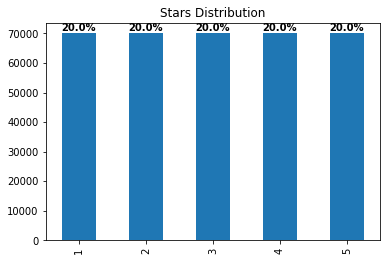

In [ ]:
#plt.hist(data['stars_str'], bins = 5)
graph = df_r['stars_str'].value_counts().loc[['1', '2', '3','4','5']].plot.bar()
plt.title('Stars Distribution')
i=0
for p in graph.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2,
             y+height*1.01,
             str(round(y_prop[i]*100,2))+'%',
             ha='center',
             weight='bold')
    i+=1
plt.show()

## useful

Text(0.5, 1.0, 'Useful')

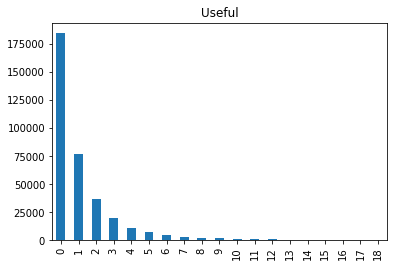

In [ ]:
u_idx = [x for x in range(19)]
graph = df_r['useful'].value_counts().loc[u_idx ].plot.bar()
plt.title("Useful")

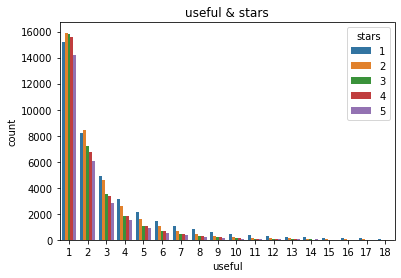

In [ ]:
df_r[df_r['useful']>0]
sns.countplot(df_r[df_r['useful']>0]['useful'],hue = df_r['stars'])
plt.title('useful & stars')
plt.legend(title = "stars")
#sns.countplot(df_r['useful'],hue = df_r['stars'])

Text(0.5, 1.0, 'Funny')

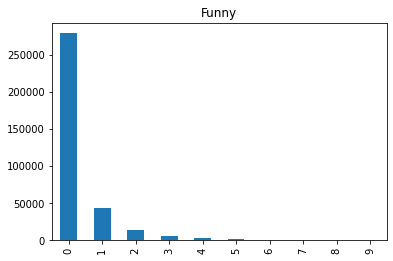

In [ ]:
f_idx = [x for x in range(10)]
graph = df_r['funny'].value_counts().loc[f_idx ].plot.bar()
plt.title("Funny")


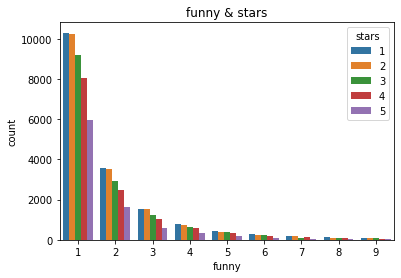

In [ ]:
sns.countplot(df_r[df_r['funny']>0]['funny'],hue = df_r['stars'])
plt.title('funny & stars')
plt.legend(title = "stars")

Text(0.5, 1.0, 'Cool')

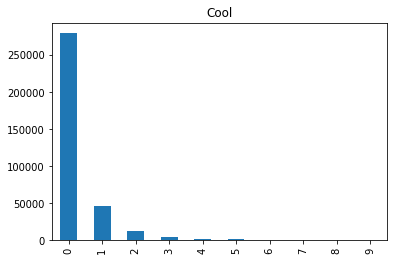

In [ ]:
c_idx = [x for x in range(10)]
graph = df_r['cool'].value_counts().loc[c_idx ].plot.bar()
plt.title("Cool")

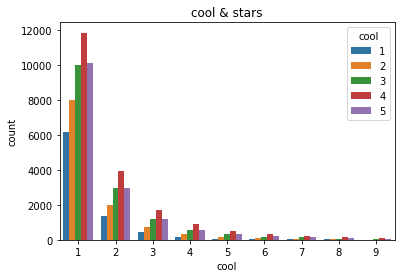

In [ ]:
sns.countplot(df_r[df_r['cool']>0]['cool'],hue = df_r['stars'])
plt.title('cool & stars')
plt.legend(title = "cool")

## wordcount

In [ ]:
df_r['txt_len'].describe()
#df_r_f['txt_len'].describe()

count    350000.000000
mean        652.843997
std         582.867603
min          50.000000
25%         269.000000
50%         479.000000
75%         836.000000
max        5000.000000
Name: txt_len, dtype: float64

## Save and Load Clean Data

In [ ]:
df_r = df_r.drop(labels = ['review_id','user_id','business_id','date','isenglish'],axis = 1)

In [ ]:
df_r.head()

,stars,useful,funny,cool,text,stars_str,txt_len
0,1,1,0,0,"Foods not fresh, taste is mediocre and for the...",1,183
1,1,3,0,0,"Hostess are totally incompetent, they told me ...",1,206
2,1,4,4,0,Do not bring your car here! Not only do they ...,1,380
3,1,1,0,0,Strike 1. Got a suit back with heavy chemical ...,1,779
4,1,1,2,1,This is like Horror Nights not at Universal St...,1,170


In [ ]:
#save clean data
#df_r.to_csv('/content/drive/MyDrive/Thesis/clean_data_large.txt',sep='<', index=False)

In [ ]:
#load the data
df_r= pd.read_csv('/content/drive/MyDrive/Thesis/clean_data_large.txt', sep ='<',header = 0)

In [ ]:
df_r[df_r.isna().any(axis=1)]

,stars,useful,funny,cool,text,stars_str,txt_len


## Data Cleaning Part 2: remove Html and punctuation

In [ ]:
def clean_Html(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

# Function for cleaning Punctuation/Special Characters
def clean_Punc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned



df_r['text'] = df_r['text'].apply(clean_Html)
df_r['text'] = df_r['text'].apply(clean_Punc)


In [ ]:
df_r[df_r.isna().any(axis=1)]

,stars,useful,funny,cool,text,stars_str,txt_len


## Bert Sentimental Analysis

In [ ]:
from transformers import pipeline 


In [ ]:
# Setting up the device for GPU usage
device = "cuda" if cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
#model_name = "distilbert-base-uncased-finetuned-sst-2-english"
#model = AutoModelForSequenceClassification.from_pretrained(model_name)
#tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis",device =0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
train = df_r['text'].tolist()
for i in range (len(train)):
    if len(train[i])>500:
      train[i] = train[i][:500]

In [ ]:
res_lab = []
res_score=[]

_ = classifier(train) 

  # positive = 1 neg = -1 neutral = 0
for i in range (len(train)):
    if _[i]['label'] == 'POSITIVE':       res_lab.append(1)
    elif _[i]['label'] == 'NEGATIVE':     res_lab.append(-1)
    else:  _.append(0)
  # get score
    res_score.append(_[i]['score'])

In [ ]:
s = pd.DataFrame({'sent_label':res_lab,'sent_score':res_score})

In [ ]:
#s.to_csv('/content/drive/MyDrive/Thesis/senti_score_large.txt',sep=',', index=False)

In [ ]:
s= pd.read_csv('/content/drive/MyDrive/Thesis/senti_score_large.txt', sep =',',header = 0)

## Save and Load Clean Data

In [ ]:
df_r_f=pd.concat([df_r, s], axis=1)

In [ ]:
df_r.describe()

,stars,useful,funny,cool,stars_str,txt_len
count,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000
mean,3.000000,1.179649,0.363980,0.339889,3.000000,652.843997
std,1.414216,2.037004,0.955216,0.893251,1.414216,582.867603
min,1.000000,0.000000,0.000000,0.000000,1.000000,50.000000
25%,2.000000,0.000000,0.000000,0.000000,2.000000,269.000000
50%,3.000000,0.000000,0.000000,0.000000,3.000000,479.000000
75%,4.000000,2.000000,0.000000,0.000000,4.000000,836.000000
max,5.000000,18.000000,9.000000,9.000000,5.000000,5000.000000


In [ ]:
df_r_f[df_r_f.isna().any(axis=1)]

,stars,useful,funny,cool,text,stars_str,txt_len,sent_label,sent_score


In [ ]:
df_r_f.head()

,stars,useful,funny,cool,text,stars_str,txt_len,sent_label,sent_score
0,1,1,0,0,Foods not fresh taste is mediocre and for the...,1,183,-1,0.999734
1,1,3,0,0,Hostess are totally incompetent they told me ...,1,206,-1,0.998250
2,1,4,4,0,Do not bring your car here Not only do they c...,1,380,-1,0.999543
3,1,1,0,0,Strike 1 Got a suit back with heavy chemical ...,1,779,-1,0.999677
4,1,1,2,1,This is like Horror Nights not at Universal St...,1,170,-1,0.977420


In [ ]:
#drop sent label and score, add new  result column by times label and score.
df_r_f["sent_res"] = df_r_f["sent_label"]*df_r_f["sent_score"]

df_r_f = df_r_f.drop(labels = ['stars_str','sent_label','sent_score','text'],axis = 1)

In [ ]:
df_r_f[df_r_f.isna().any(axis=1)]

,stars,useful,funny,cool,txt_len,sent_res


In [ ]:
train_df_x = df_r_f.drop(labels = ['stars'],axis = 1)
train_df_y = df_r_f[['stars']]

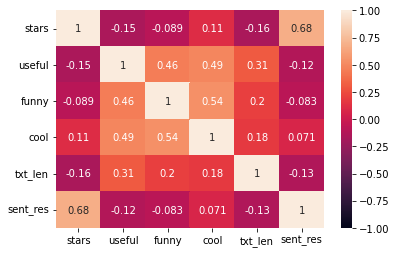

In [ ]:
#sns.heatmap(df_r_f.corr(),vmin=-1, vmax=1, annot=True)

VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
df_r_f.sample(5)

,stars,useful,funny,cool,txt_len,sent_res
40175,1,0,0,0,801,-0.999376
112328,2,3,1,3,554,0.971345
321390,5,0,0,0,446,0.995463
22629,1,1,1,0,539,-0.999587
117273,2,2,1,0,655,-0.999238


In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_r_f.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_r_f.values, i)
                          for i in range(len(df_r_f.columns))]
  
print(vif_data)

    feature       VIF
0     stars  2.002632
1    useful  1.985257
2     funny  1.772698
3      cool  1.908090
4   txt_len  2.231388
5  sent_res  1.248944


# Models

## Model 1 BERT review text predict score 

## Model 3 Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_df_x, train_df_y, test_size=0.2, random_state=200)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=200)

In [ ]:
logisticRegr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
mlr= logisticRegr.fit(x_train, y_train)
# mlr coefficients
print(mlr.intercept_)
print(mlr.coef_)

[-0.21463693 -0.13321466  0.04089883  0.07816891  0.22878385]
[[ 1.84399712e-01 -5.63997738e-03 -4.49286999e-01 -6.01245348e-05
  -1.13231194e+00]
 [ 5.07479520e-02  5.65828818e-02 -2.10862771e-01  1.68189433e-04
  -8.82584211e-01]
 [-7.54993472e-02  6.94322853e-02  1.38429020e-01  3.50260079e-04
  -7.97787690e-02]
 [-1.14744703e-01 -1.55653099e-02  3.27477930e-01  7.44881523e-05
   8.72614226e-01]
 [-4.49036137e-02 -1.04809880e-01  1.94242820e-01 -5.32813130e-04
   1.22206069e+00]]


In [ ]:
# train score
score = logisticRegr.score(x_train, y_train)
print(score)  #0.39706     #large 0.3884
#validation score
score = logisticRegr.score(x_val, y_val)
print(score)  #0.39606   #large 0.3861
#test score
score = logisticRegr.score(x_test, y_test)
print(score)  #0.39606   #large 0.3856

0.3884484126984127
0.38607142857142857
0.3856428571428571


## Model 4 Binning with Logistic Regression

In [ ]:
df_r_f_bin = df_r_f.replace({'stars' : { 2 : 1, 4 : 5 }})
#df_r_f_bin ['stars'].unique()

In [ ]:
train_df_x = df_r_f_bin.drop(labels = ['stars'],axis = 1)
train_df_y = df_r_f_bin[['stars']]
x_train, x_test, y_train, y_test = train_test_split(train_df_x, train_df_y, test_size=0.25, random_state=200)
logisticRegr = LogisticRegression(multi_class='multinomial', solver='lbfgs')
mlr_b =logisticRegr.fit(x_train, y_train)

# mlr_b coefficients
print(mlr_b.classes_)
print(mlr_b.intercept_)
print(mlr_b.coef_)

# train score
score = logisticRegr.score(x_train, y_train)
print(score)  #0.713952           #large  0.701657
#validation score
score = logisticRegr.score(x_test, y_test)
print(score)  #0.713504           #large  0.69981

[1 3 5]
[-0.26316904 -0.20668005  0.46984909]
[[ 1.46166951e-01  1.97810924e-01 -5.52139049e-01  1.63197522e-04
  -1.06068031e+00]
 [-7.15503081e-02  6.11065384e-03  1.53978049e-01  1.50919561e-04
   2.49989166e-02]
 [-7.46166434e-02 -2.03921578e-01  3.98161001e-01 -3.14117083e-04
   1.03568140e+00]]
0.7016571428571429
0.6998057142857143
